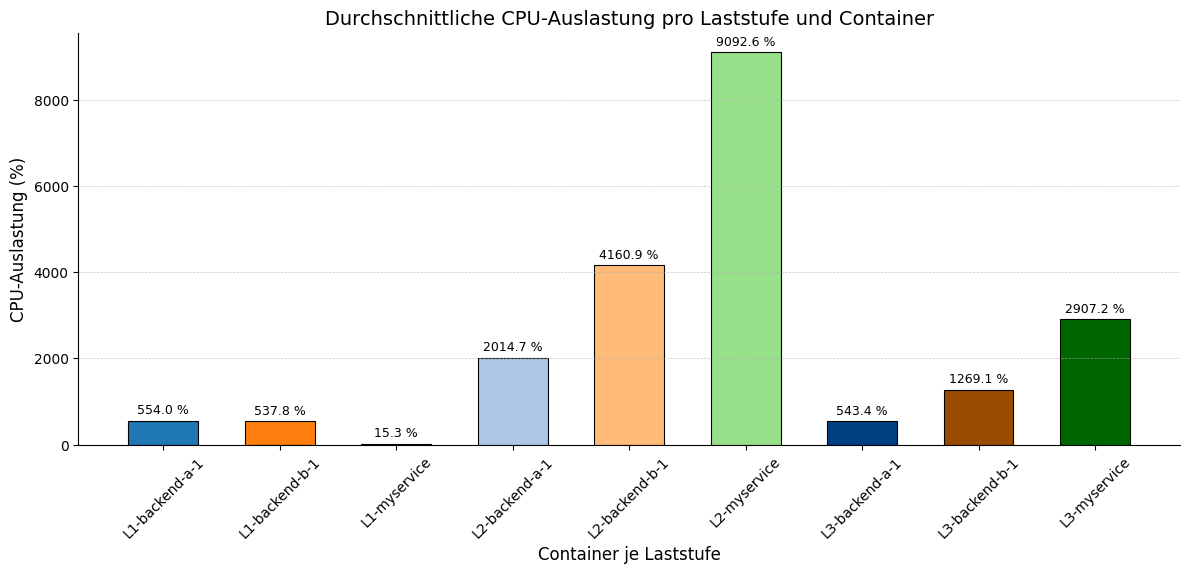


Tabelle für: Durchschnittliche CPU-Auslastung
Profil/Container CPU-Auslastung (%)
  L1-backend-a-1            554.0 %
  L1-backend-b-1            537.8 %
    L1-myservice             15.3 %
  L2-backend-a-1           2014.7 %
  L2-backend-b-1           4160.9 %
    L2-myservice           9092.6 %
  L3-backend-a-1            543.4 %
  L3-backend-b-1           1269.1 %
    L3-myservice           2907.2 %


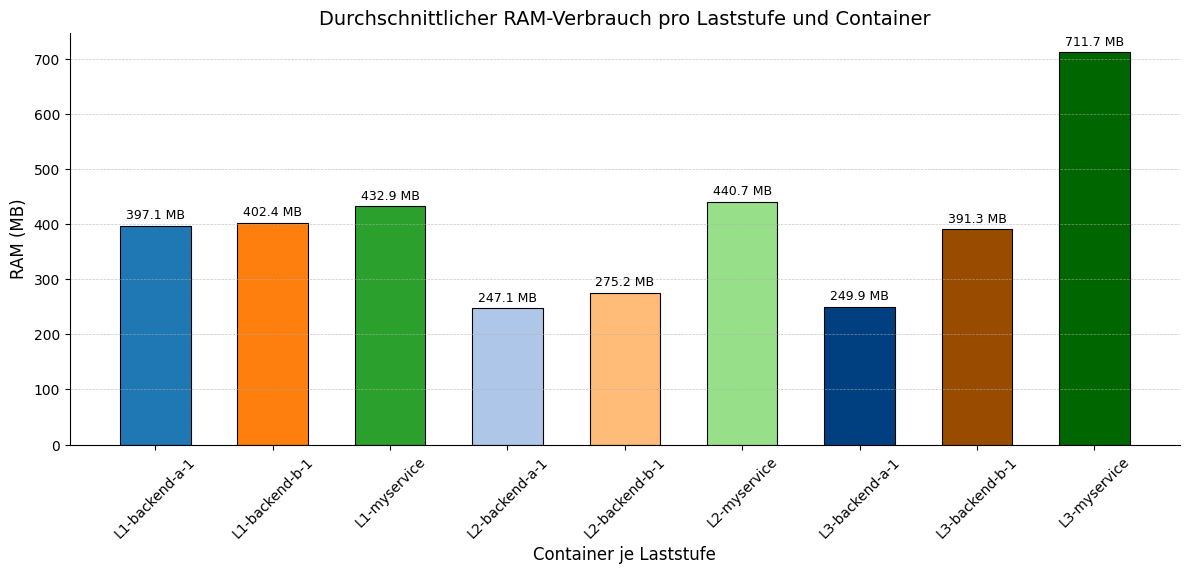


Tabelle für: Durchschnittlicher RAM-Verbrauch
Profil/Container RAM (MB)
  L1-backend-a-1 397.1 MB
  L1-backend-b-1 402.4 MB
    L1-myservice 432.9 MB
  L2-backend-a-1 247.1 MB
  L2-backend-b-1 275.2 MB
    L2-myservice 440.7 MB
  L3-backend-a-1 249.9 MB
  L3-backend-b-1 391.3 MB
    L3-myservice 711.7 MB


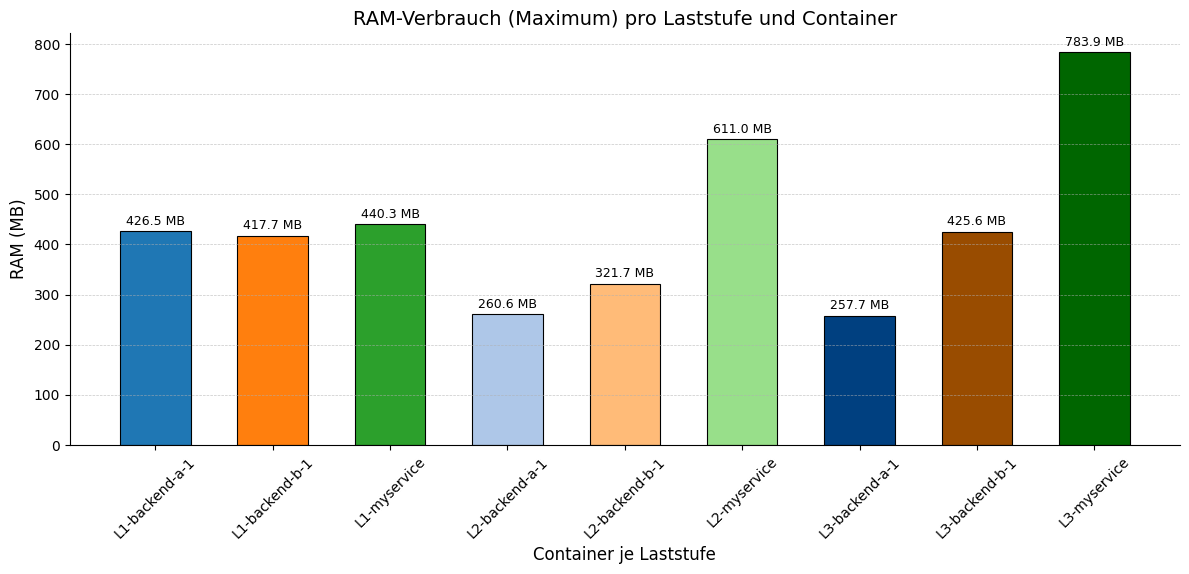


Tabelle für: RAM-Verbrauch (Maximum)
Profil/Container RAM (MB)
  L1-backend-a-1 426.5 MB
  L1-backend-b-1 417.7 MB
    L1-myservice 440.3 MB
  L2-backend-a-1 260.6 MB
  L2-backend-b-1 321.7 MB
    L2-myservice 611.0 MB
  L3-backend-a-1 257.7 MB
  L3-backend-b-1 425.6 MB
    L3-myservice 783.9 MB


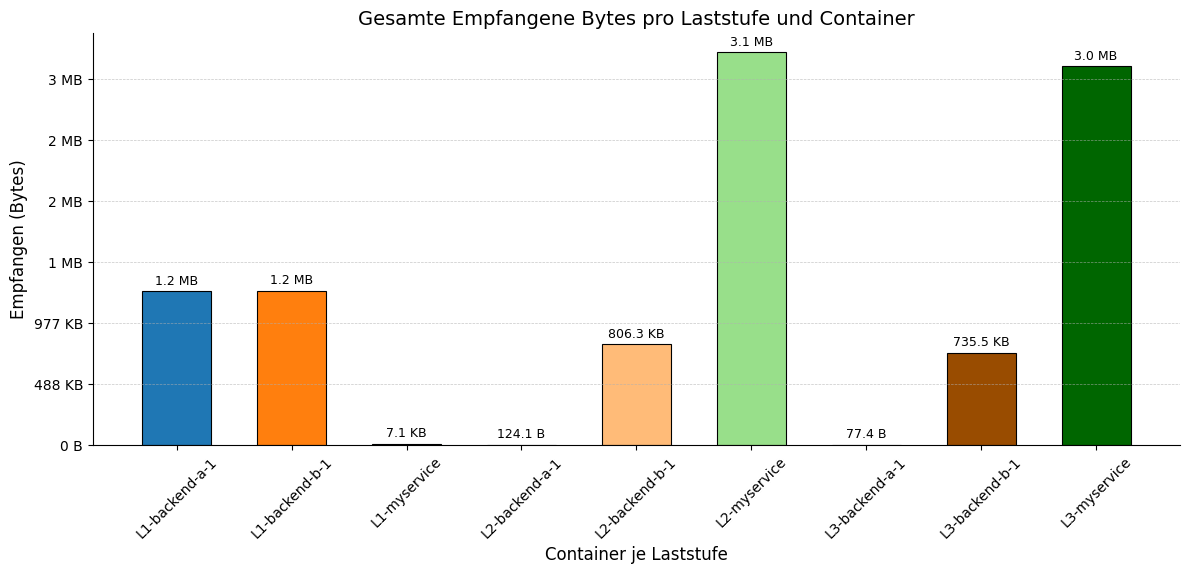


Tabelle für: Gesamte Empfangene Bytes
Profil/Container Empfangen (Bytes)
  L1-backend-a-1            1.2 MB
  L1-backend-b-1            1.2 MB
    L1-myservice            7.1 KB
  L2-backend-a-1           124.1 B
  L2-backend-b-1          806.3 KB
    L2-myservice            3.1 MB
  L3-backend-a-1            77.4 B
  L3-backend-b-1          735.5 KB
    L3-myservice            3.0 MB


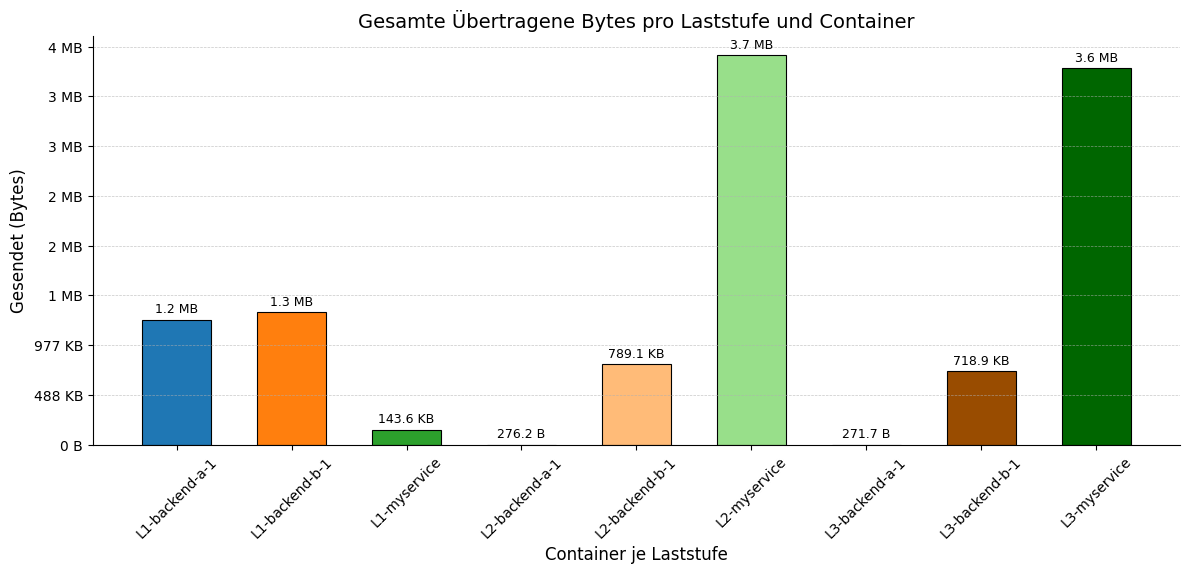


Tabelle für: Gesamte Übertragene Bytes
Profil/Container Gesendet (Bytes)
  L1-backend-a-1           1.2 MB
  L1-backend-b-1           1.3 MB
    L1-myservice         143.6 KB
  L2-backend-a-1          276.2 B
  L2-backend-b-1         789.1 KB
    L2-myservice           3.7 MB
  L3-backend-a-1          271.7 B
  L3-backend-b-1         718.9 KB
    L3-myservice           3.6 MB


In [ ]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Hilfsfunktionen
def format_bytes_yaxis(ax):
    def human_readable_bytes(x, pos):
        for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
            if abs(x) < 1024.0:
                return f"{x:.0f} {unit}"
            x /= 1024.0
        return f"{x:.0f} PB"
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(human_readable_bytes))

def format_bytes_value(value):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if abs(value) < 1024.0:
            return f"{value:.1f} {unit}"
        value /= 1024.0
    return f"{value:.1f} PB"

# Containernamen
container_names = ["backend-a-1", "backend-b-1", "myservice"]

# Farben
farben = {
    "L1-backend-a-1": "#1f77b4", "L1-backend-b-1": "#ff7f0e", "L1-myservice": "#2ca02c",
    "L2-backend-a-1": "#aec7e8", "L2-backend-b-1": "#ffbb78", "L2-myservice": "#98df8a",
    "L3-backend-a-1": "#004080", "L3-backend-b-1": "#994c00", "L3-myservice": "#006600"
}

# Zeiträume
testraeume = {
    "L1": (datetime.strptime("2025-05-25 12:22:11", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2025-05-25 13:10:58", "%Y-%m-%d %H:%M:%S")),
    "L2": (datetime.strptime("2025-05-25 12:22:11", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2025-05-25 14:24:05", "%Y-%m-%d %H:%M:%S")),
    "L3": (datetime.strptime("2025-05-25 12:22:11", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2025-05-25 14:48:21", "%Y-%m-%d %H:%M:%S"))
}

# Prometheus
prometheus_url = "http://localhost:9090"
step = "10s"

# Metriken
metriken = [
    {
        "name": "Durchschnittliche CPU-Auslastung",
        "query_template": 'avg_over_time(dockerstats_cpu_usage_ratio{{name="{container}"}}[5m]) * 100',
        "ylabel": "CPU-Auslastung (%)",
        "value_formatter": lambda v: f"{v:.1f} %"
    },
    {
        "name": "Durchschnittlicher RAM-Verbrauch",
        "query_template": 'avg_over_time(dockerstats_memory_usage_rss_bytes{{name="{container}"}}[5m]) / 1024 / 1024',
        "ylabel": "RAM (MB)",
        "value_formatter": lambda v: f"{v:.1f} MB"
    },
    {
        "name": "RAM-Verbrauch (Maximum)",
        "query_template": 'max_over_time(dockerstats_memory_usage_rss_bytes{{name="{container}"}}[5m]) / 1024 / 1024',
        "ylabel": "RAM (MB)",
        "value_formatter": lambda v: f"{v:.1f} MB"
    },
    {
        "name": "Gesamte Empfangene Bytes",
        "query_template": 'increase(dockerstats_network_received_bytes{{name="{container}"}}[1m])',
        "ylabel": "Empfangen (Bytes)",
        "value_formatter": format_bytes_value
    },
    {
        "name": "Gesamte Übertragene Bytes",
        "query_template": 'increase(dockerstats_network_transmitted_bytes{{name="{container}"}}[1m])',
        "ylabel": "Gesendet (Bytes)",
        "value_formatter": format_bytes_value
    }
]

# Auswertung
for metric in metriken:
    results = {}
    for laststufe, (start_dt, end_dt) in testraeume.items():
        start = int(start_dt.timestamp())
        end = int(end_dt.timestamp())
        for container in container_names:
            label = f"{laststufe}-{container}"
            query = metric["query_template"].format(container=container)
            response = requests.get(f"{prometheus_url}/api/v1/query_range", params={
                "query": query,
                "start": start,
                "end": end,
                "step": step
            })
            data = response.json()
            if data["status"] == "success" and data["data"]["result"]:
                values = [float(v[1]) for v in data["data"]["result"][0]["values"]]
                results[label] = np.mean(values)

    # Visualisierung
    labels = list(results.keys())
    values = list(results.values())
    farben_liste = [farben.get(label, "#333333") for label in labels]
    xpos = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(xpos, values, color=farben_liste, width=0.6, edgecolor='black', linewidth=0.8)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        text = metric["value_formatter"](height)
        ax.text(bar.get_x() + bar.get_width() / 2, height + max(values) * 0.01,
                text, ha='center', va='bottom', fontsize=9)

    ax.set_title(f"{metric['name']} pro Laststufe und Container", fontsize=14)
    ax.set_ylabel(metric["ylabel"], fontsize=12)
    ax.set_xlabel("Container je Laststufe", fontsize=12)
    ax.set_xticks(xpos)
    ax.set_xticklabels(labels, rotation=45, fontsize=10)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    if "Bytes" in metric["ylabel"]:
        format_bytes_yaxis(ax)



    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

    # Ausgabe als Tabelle
    df = pd.DataFrame({
        "Profil/Container": labels,
        metric["ylabel"]: [metric["value_formatter"](v) for v in values]
    })
    print(f"\nTabelle für: {metric['name']}")
    print(df.to_string(index=False))


===== Auswertung für L1 =====

⚠️ Keine Daten für: Fehleranzahl 5xx pro Instanz – L1


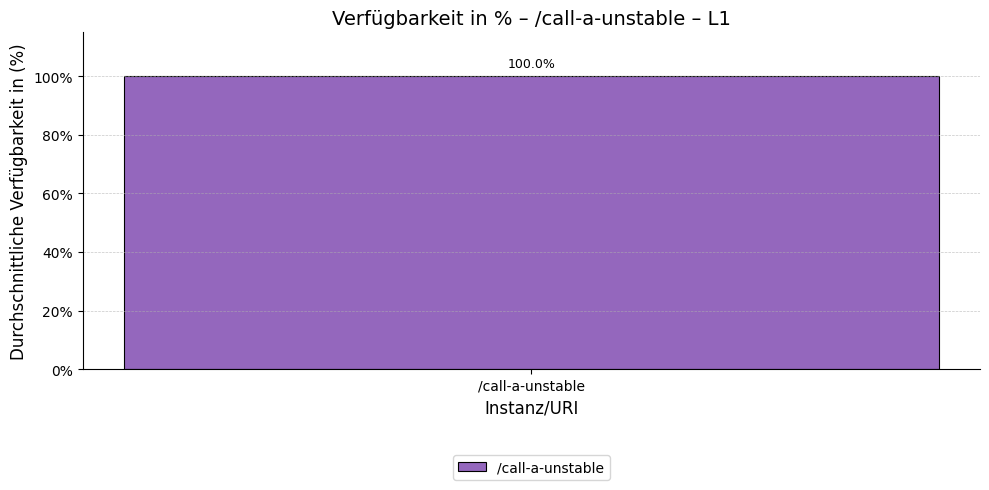


===== Auswertung für L2 =====



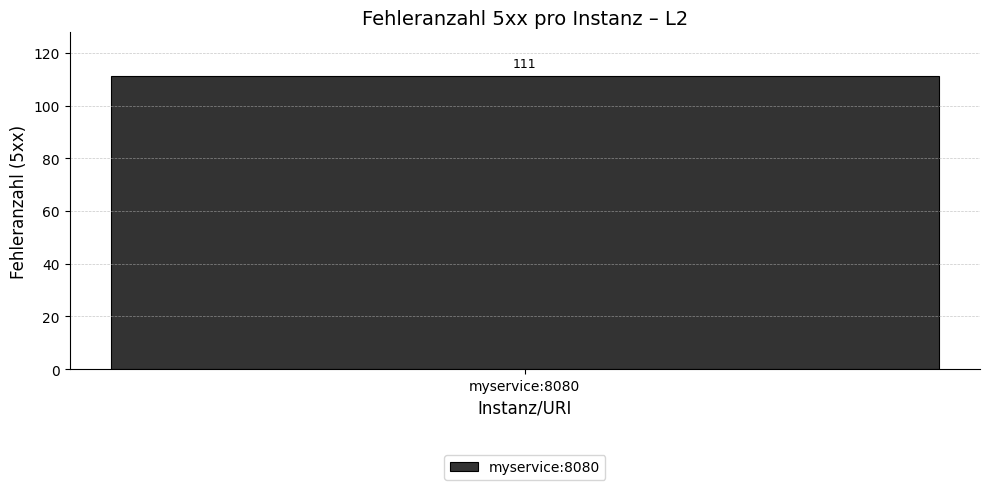

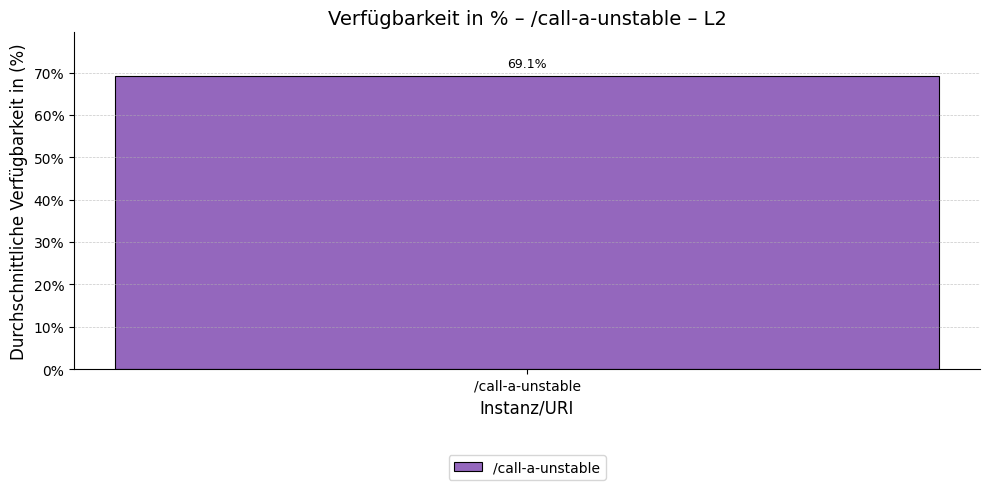


===== Auswertung für L3 =====



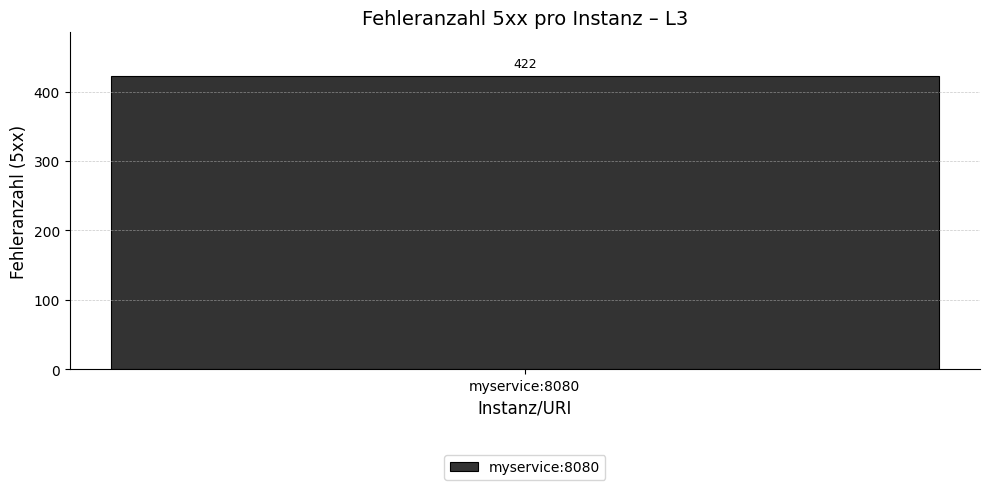

⚠️ Keine Daten für: Verfügbarkeit in % – /call-a-unstable – L3


In [127]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# --- Hilfsfunktionen ---
def format_percent_yaxis(ax):
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

# --- Konfiguration ---
testraeume = {
    "L1": ("2025-05-25 09:58:37", "2025-05-25 09:58:57"),
    "L2": ("2025-05-25 10:01:30", "2025-05-25 10:05:29"),
    "L3": ("2025-05-25 10:10:05", "2025-05-25 10:38:02"),
}

prometheus_url = "http://localhost:9090"
step = "10s"

metriken = [
    {
        "name": "Fehleranzahl 5xx pro Instanz",
        "query": 'sum by (instance) (increase(http_server_requests_seconds_count{uri="/call-a-unstable", status=~"5.."}[10s]))',
        "ylabel": "Fehleranzahl (5xx)",
        "einheit": "count"
    },
    {
        "name": "Verfügbarkeit in % – /call-a-unstable",
        "query": '100 * sum by (uri) (increase(http_server_requests_seconds_count{uri="/call-a-unstable", status=~"2.."}[10s])) / sum by (uri) (increase(http_server_requests_seconds_count{uri="/call-a-unstable", status=~"2..|5.."}[10s]))',
        "ylabel": "Durchschnittliche Verfügbarkeit in (%)",
        "einheit": "percent"
    }
]

farben = {
    "backend-a-1": "#1f77b4",
    "backend-b-1": "#ff7f0e",
    "myservice": "#2ca02c",
    "/call-a-unstable": "#9467bd"
}

# --- Auswertung pro Laststufe ---
for laststufe, (start_str, end_str) in testraeume.items():
    print(f"\n===== Auswertung für {laststufe} =====\n")
    start = int(datetime.strptime(start_str, "%Y-%m-%d %H:%M:%S").timestamp())
    end = int(datetime.strptime(end_str, "%Y-%m-%d %H:%M:%S").timestamp())

    for metric in metriken:
        response = requests.get(f"{prometheus_url}/api/v1/query_range", params={
            "query": metric["query"],
            "start": start,
            "end": end,
            "step": step
        })

        data = response.json()
        df_list = []

        for serie in data.get("data", {}).get("result", []):
            label = serie["metric"].get("instance") or serie["metric"].get("uri") or "unknown"
            timestamps = [datetime.fromtimestamp(float(v[0])) for v in serie["values"]]
            values = [float(v[1]) for v in serie["values"]]
            relative_time = [(t - timestamps[0]).total_seconds() for t in timestamps]
            df = pd.DataFrame({"relative_time": relative_time, label: values})
            df.set_index("relative_time", inplace=True)
            df_list.append(df)

        if df_list:
            df_all = pd.concat(df_list, axis=1)
            means = df_all.mean()

            labels = means.index.to_list()
            values = means.values
            farben_liste = [farben.get(name, "#333333") for name in labels]
            spacing_factor = 1
            xpos = np.arange(len(labels)) * spacing_factor

            fig, ax = plt.subplots(figsize=(10, 5))
            bars = ax.bar(xpos, values, color=farben_liste, width=0.9, edgecolor='black', linewidth=0.8)

            for i, bar in enumerate(bars):
                height = bar.get_height()
                label = f"{height:.1f}%" if metric["einheit"] == "percent" else f"{height:.0f}"
                ax.text(bar.get_x() + bar.get_width() / 2, height + max(values) * 0.02,
                        label, ha='center', va='bottom', fontsize=9)

            ax.set_title(f"{metric['name']} – {laststufe}", fontsize=14)
            ax.set_ylabel(metric["ylabel"], fontsize=12)
            ax.set_xlabel("Instanz/URI", fontsize=12)
            ax.set_xticks(xpos)
            ax.set_xticklabels(labels, fontsize=11)
            ax.tick_params(axis='both', labelsize=10)
            ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)

            if metric["einheit"] == "percent":
                format_percent_yaxis(ax)

            ax.set_ylim(0, max(values) * 1.15)
            ax.legend(bars, labels, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=len(labels))
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.25)
            plt.show()

        else:
            print(f"⚠️ Keine Daten für: {metric['name']} – {laststufe}")



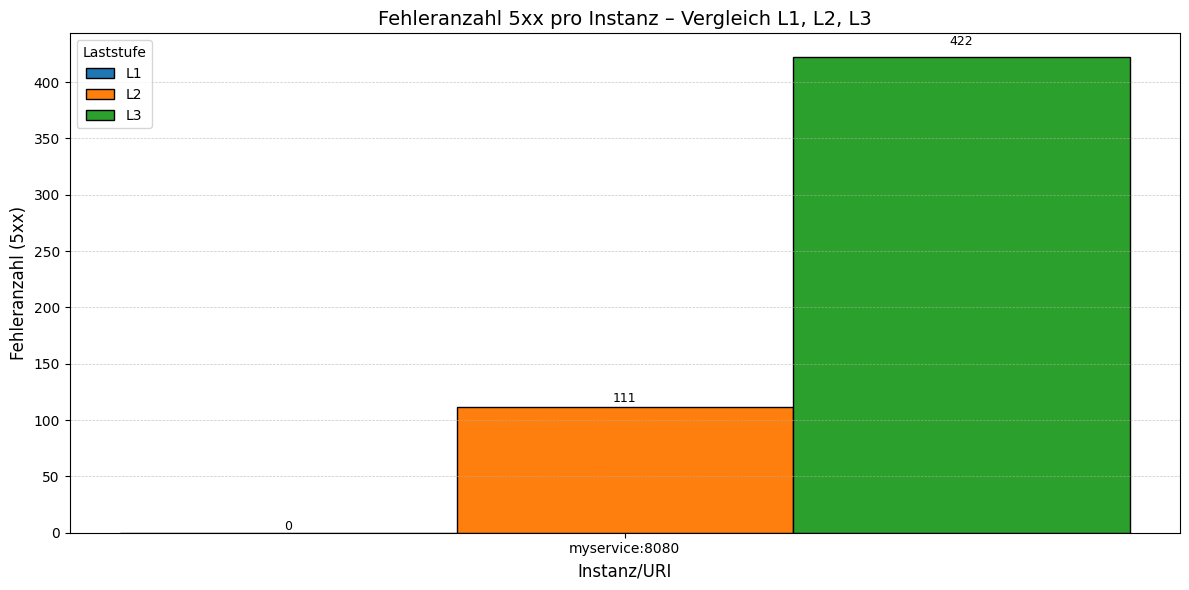

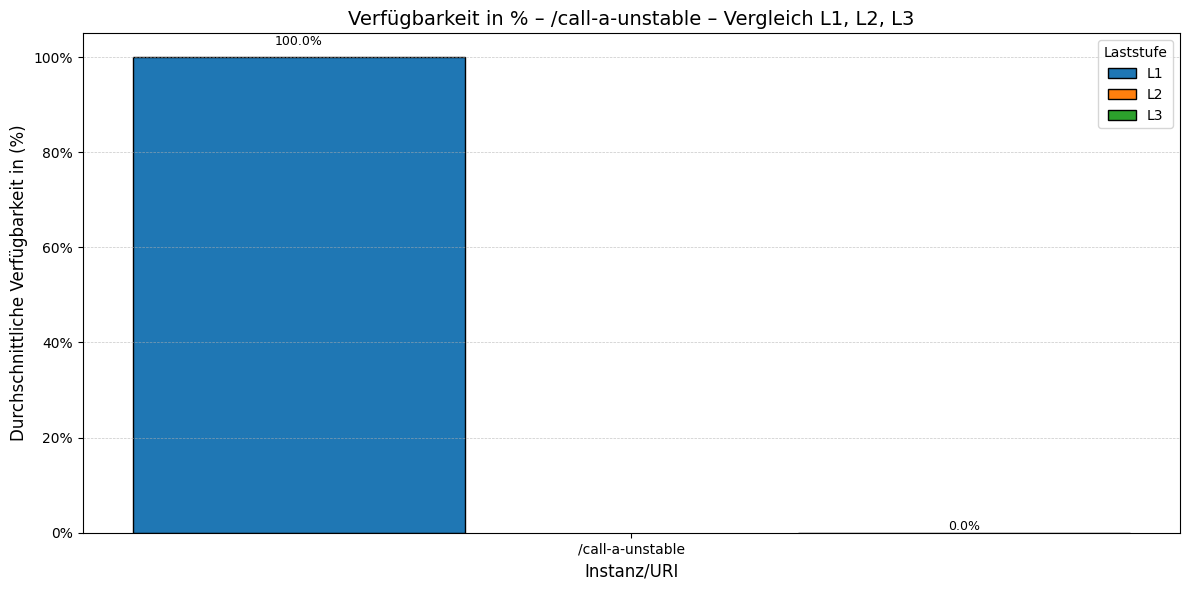

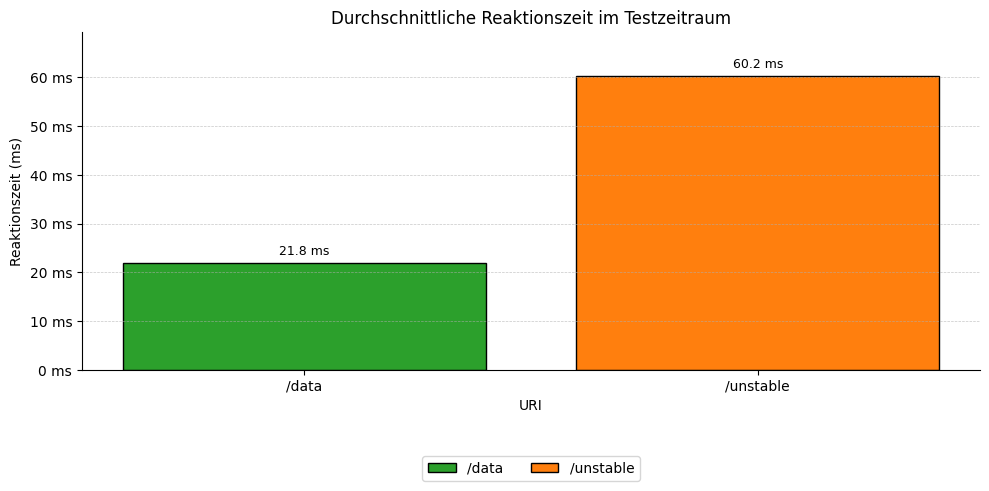

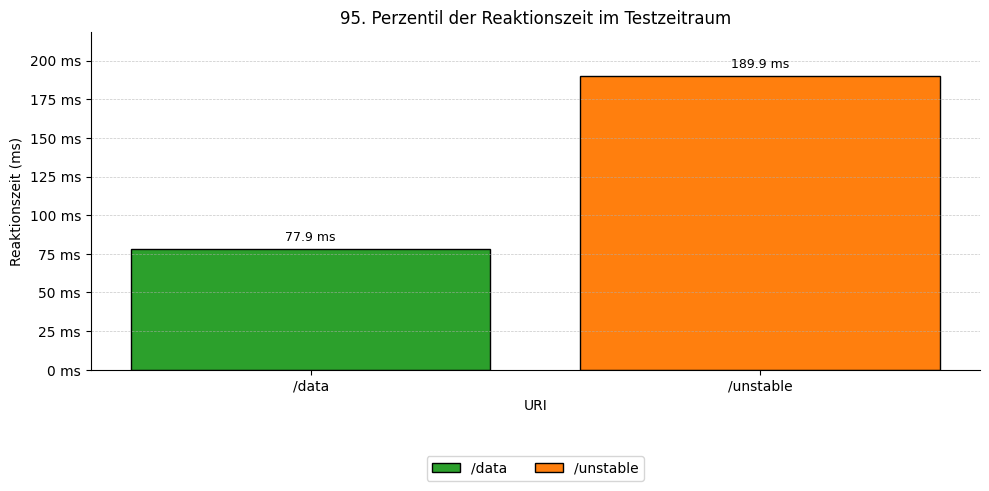

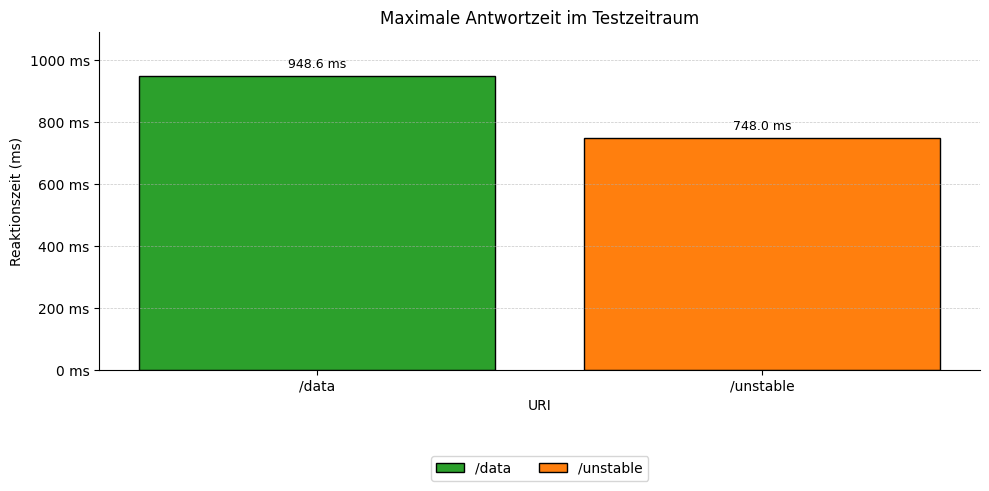

In [124]:
# --- L1 ---
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# --- Hilfsfunktionen ---
def format_seconds_yaxis(ax):
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f} s"))

def format_ms_yaxis(ax):
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f} ms"))

# --- Konfiguration ---
start_time = datetime.strptime("2025-05-25 10:01:27", "%Y-%m-%d %H:%M:%S")
end_time = datetime.strptime("2025-05-25 10:05:29", "%Y-%m-%d %H:%M:%S")
start = int(start_time.timestamp())
end = int(end_time.timestamp())
step = "10s"
prometheus_url = "http://localhost:9090"

# --- Abfragen ---
queries = [
    {
        "title": "Durchschnittliche Reaktionszeit im Testzeitraum",
        "query": """
        sum by (uri) (rate(http_client_reaktionszeit_seconds_sum[10s]))
        /
        sum by (uri) (rate(http_client_reaktionszeit_seconds_count[10s]))
        """
    },
    {
        "title": "95. Perzentil der Reaktionszeit im Testzeitraum",
        "query": """
        histogram_quantile(0.95, sum(rate(http_client_reaktionszeit_seconds_bucket[10s])) by (uri, le))
        """
    },
    {
        "title": "Maximale Antwortzeit im Testzeitraum",
        "query": """
        max(http_client_reaktionszeit_seconds_max{job="myservice"}) by (uri)
        """
    }
]

# --- Verarbeitung ---
for entry in queries:
    response = requests.get(f"{prometheus_url}/api/v1/query_range", params={
        "query": entry["query"],
        "start": start,
        "end": end,
        "step": step
    })

    data = response.json()
    df_list = []

    for serie in data.get("data", {}).get("result", []):
        label = serie["metric"].get("uri", "unknown")
        timestamps = [datetime.fromtimestamp(float(v[0])) for v in serie["values"]]
        values = [float(v[1]) for v in serie["values"]]
        relative_time = [(t - timestamps[0]).total_seconds() for t in timestamps]
        df = pd.DataFrame({"relative_time": relative_time, label: values})
        df.set_index("relative_time", inplace=True)
        df_list.append(df)

    if df_list:
        df_all = pd.concat(df_list, axis=1)
        means_raw = df_all.max().round(6) if "max" in entry["title"].lower() else df_all.mean().round(6)
        max_raw = means_raw.max()

        # Dynamische Skalierung
        auto_unit = "ms" if max_raw < 1 else "s"
        scaled_values = [v * 1000 if auto_unit == "ms" else v for v in means_raw]
        scaled_labels = [f"{v:.1f} {auto_unit}" for v in scaled_values]
        labels = means_raw.index.to_list()
        xpos = np.arange(len(labels))

        fig, ax = plt.subplots(figsize=(10, 5))
        bars = ax.bar(xpos, scaled_values, color=["#2ca02c", "#ff7f0e"], edgecolor='black')

        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + max(scaled_values) * 0.02,
                    scaled_labels[i], ha='center', va='bottom', fontsize=9)

        ax.set_title(entry["title"])
        ax.set_ylabel(f"Reaktionszeit ({auto_unit})")
        ax.set_xlabel("URI")
        ax.set_xticks(xpos)
        ax.set_xticklabels(labels, fontsize=11)
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(0, max(scaled_values) * 1.15)

        if auto_unit == "ms":
            format_ms_yaxis(ax)
        else:
            format_seconds_yaxis(ax)

        ax.legend(bars, labels, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=len(labels))
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.25)
        plt.show()
    else:
        print(f"⚠️ Keine Daten gefunden für: {entry['title']}")
